In [0]:
!pip3 install kaggle
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

from google.colab import drive
drive.mount('/content/gdrive')

!kaggle competitions download -c human-protein-atlas-image-classification
!unzip -qq train.zip -d train | awk 'BEGIN {ORS=" "} {if(NR%500==0) print "."}'
!unzip -qq test.zip -d test | awk 'BEGIN {ORS=" "} {if(NR%500==0) print "."}'
!rm test.zip
!rm train.zip

Download 100%.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
  0% 0.00/446k [00:00<?, ?B/s]
100% 446k/446k [00:00<00:00, 30.7MB/s]
  0% 0.00/1.22M [00:00<?, ?B/s]
100% 1.22M/1.22M [00:00<00:00, 40.9MB/s]
 58% 2.51G/4.37G [00:27<00:20, 96.1MB/s]

In [0]:
!ls

sample_data


In [2]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from keras.models import Sequential, Model,load_model
from keras.layers import Dense, Dropout, Flatten, merge
from keras.layers import Input, Activation, Dense, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.applications import ResNet50,DenseNet121,Xception
from keras import backend as K
import os
from sklearn.utils import shuffle
import random
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,Callback
from sklearn.metrics import f1_score
from keras.optimizers import Adam, SGD
import PIL
from PIL import Image
import _pickle as cPickle
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

Using TensorFlow backend.


In [0]:
def f1_score_K(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)
  
def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)
  
def f1_score_macro(y_true, y_pred):
    y_true, y_pred, = np.array(y_true), np.array(y_pred)
    score = f1_score(y_true, y_pred, average='macro')
    return score

def rotate(img):
    rows = img.shape[0]
    cols = img.shape[1]
    angle = np.random.choice((10, 20, 30))#, 40, 50, 60, 70, 80, 90))
    rotation_M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    img = cv2.warpAffine(img, rotation_M, (cols, rows))
    return img

def rotate_bound(image, size):
    #credits http://www.pyimagesearch.com/2017/01/02/rotate-images-correctly-with-opencv-and-python/
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    angle = np.random.randint(10,180)

    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    output = cv2.resize(cv2.warpAffine(image, M, (nW, nH)), (size, size))
    return output

def perspective(img):
    rows = img.shape[0]
    cols = img.shape[1]

    shrink_ratio1 = np.random.randint(low=85, high=110, dtype=int) / 100
    shrink_ratio2 = np.random.randint(low=85, high=110, dtype=int) / 100

    zero_point = rows - np.round(rows * shrink_ratio1, 0)
    max_point_row = np.round(rows * shrink_ratio1, 0)
    max_point_col = np.round(cols * shrink_ratio2, 0)

    src = np.float32([[zero_point, zero_point], [max_point_row-1, zero_point], [zero_point, max_point_col+1], [max_point_row-1, max_point_col+1]])
    dst = np.float32([[0, 0], [rows, 0], [0, cols], [rows, cols]])

    perspective_M = cv2.getPerspectiveTransform(src, dst)

    img = cv2.warpPerspective(img, perspective_M, (cols,rows))#, borderValue=mean_pix)
    return img

def shift(img):
    rows = img.shape[0]
    cols = img.shape[1]

    shift_ratio1 = (random.random() * 2 - 1) * np.random.randint(low=3, high=15, dtype=int)
    shift_ratio2 = (random.random() * 2 - 1) * np.random.randint(low=3, high=15, dtype=int)

    shift_M = np.float32([[1,0,shift_ratio1], [0,1,shift_ratio2]])
    img = cv2.warpAffine(img, shift_M, (cols, rows))#, borderValue=mean_pix)
    return img
  
def batch_generator_train(zip_list, img_size, batch_size, is_train=True, shuffle=True):
    number_of_batches = np.ceil(len(zip_list) / batch_size)
    if shuffle == True:
        random.shuffle(zip_list)
    counter = 0
    while True:
        if shuffle == True:
            random.shuffle(zip_list)

        batch_files = zip_list[batch_size*counter:batch_size*(counter+1)]
        image_list = []
        mask_list = []

        for file, mask in batch_files:

            image=open_rgby(file,img_size)  

            rnd_flip = np.random.randint(2, dtype=int)
            rnd_rotate = np.random.randint(2, dtype=int)
            rnd_zoom = np.random.randint(2, dtype=int)
            rnd_shift = np.random.randint(2, dtype=int)

            if (rnd_flip == 1) & (is_train == True):
                rnd_flip = np.random.randint(3, dtype=int) - 1
                image = cv2.flip(image, rnd_flip)

            if (rnd_rotate == 1) & (is_train == True):
                image = rotate_bound(image, img_size)

            if (rnd_zoom == 1) & (is_train == True):
                image = perspective(image)

            if (rnd_shift == 1) & (is_train == True):
                image = shift(image)

            image_list.append(image)
            mask_list.append(mask)

        counter += 1
        image_list = np.array(image_list)
        mask_list = np.array(mask_list)

        yield (image_list, mask_list)

        if counter == number_of_batches:
            if shuffle == True:
                random.shuffle(zip_list)
            counter = 0
            
def batch_generator_test(zip_list, img_size, batch_size, shuffle=True):
    number_of_batches = np.ceil(len(zip_list)/batch_size)
    print(len(zip_list), number_of_batches)
    counter = 0
    if shuffle:
        random.shuffle(zip_list)
    while True:
        batch_files = zip_list[batch_size*counter:batch_size*(counter+1)]
        image_list = []
        mask_list = []

        for file, mask in batch_files:
            image=open_rgby(file,img_size)  
            image_list.append(image)
            mask_list.append(mask)

        counter += 1
        image_list = np.array(image_list)
        mask_list = np.array(mask_list)

        yield (image_list, mask_list)

        if counter == number_of_batches:
            random.shuffle(zip_list)
            counter = 0
            

def predict_generator(files, img_size, batch_size):
    number_of_batches = np.ceil(len(files) / batch_size)
    print(len(files), number_of_batches)
    counter = 0
    int_counter = 0

    while True:
            beg = batch_size * counter
            end = batch_size * (counter + 1)
            batch_files = files[beg:end]
            image_list = []

            for file in batch_files:
                int_counter += 1
                image=open_rgby(file,img_size)  
                rnd_flip = np.random.randint(2, dtype=int)
                rnd_rotate = np.random.randint(2, dtype=int)
                rnd_zoom = np.random.randint(2, dtype=int)
                rnd_shift = np.random.randint(2, dtype=int)

                if rnd_flip == 1:
                    rnd_flip = np.random.randint(3, dtype=int) - 1
                    image = cv2.flip(image, rnd_flip)

                if rnd_rotate == 1:
                    image = rotate_bound(image, img_size)

                if rnd_zoom == 1:
                    image = perspective(image)

                if rnd_shift == 1:
                    image = shift(image)

                image_list.append(image)

            counter += 1

            image_list = np.array(image_list)

            yield (image_list)
            
def open_rgby(file, img_size): #a function that reads RGBY image
    colors = ['red','green','blue']#,'yellow']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.resize(cv2.imread((file+'_'+color+'.png'), flags),(img_size,img_size))
           for color in colors]
    return np.stack(img, axis=-1)            

In [0]:
TRAIN = 'train/'
TEST = 'test/'
LABELS = 'train.csv'
SAMPLE = 'sample_submission.csv'
DRIVE='/content/gdrive/My Drive/atlas'
DATA='data/'
MODELS='models/'
OUTPUT_CSV='output_csv/'
FOLD=4
RANDOM_STATE=15
IMG_SIZE=512
BATCH=8
NUM_CLASSES=23

In [0]:
os.listdir(DRIVE)

['data', 'models', 'output_csv']

In [0]:

file_name=os.path.join(DRIVE,DATA, f'Main_{FOLD}_{RANDOM_STATE}.pkl')
#file_name=os.path.join(DRIVE,DATA, f'test_{4}_{RANDOM_STATE}.pkl')
with open(file_name, 'rb') as f:
    train_list= cPickle.load(f)
train=train_list[0]
val=train_list[1]

In [0]:
len(train)

2

In [6]:
def create_model():
  base_model = DenseNet121(include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), pooling='avg', weights='imagenet')
  x = base_model.output
  x = Dense(2048,activation='relu')(x)
  x = Dropout(0.25)(x)
  output = Dense(NUM_CLASSES, activation='sigmoid')(x)
  return Model(input=base_model.inputs,outputs = output)
model=create_model()

29089792/29084464 [==============================] - 2s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`
  import sys


In [7]:
model_name=os.path.join(DRIVE,MODELS,f'dense_main_{FOLD}_{RANDOM_STATE}')
model_name
                        

'/content/gdrive/My Drive/atlas/models/dense_main_4_15'

In [8]:
name=model_name+'_24-0.0860.hdf5'
name

'/content/gdrive/My Drive/atlas/models/dense_main_2_15_24-0.0860.hdf5'

In [0]:
model=load_model(name,custom_objects={'f1_score_K':f1_score_K})

In [0]:
class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        lr = self.model.optimizer.lr
        decay = self.model.optimizer.decay
        iterations = self.model.optimizer.iterations
        lr_with_decay = lr / (1. + decay * K.cast(iterations, K.dtype(decay)))

        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show()
        print('Epoch ', self.i, K.eval(lr_with_decay))
        
plot_losses = PlotLosses()

In [0]:
callbacks = [ModelCheckpoint(model_name+'_{epoch:02d}-{val_loss:.4f}.hdf5', monitor='val_loss', save_best_only=True, verbose=2,mode='min'),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.0000000001),
             EarlyStopping(monitor='val_loss', patience=6, mode='min', verbose=0),
             plot_losses]

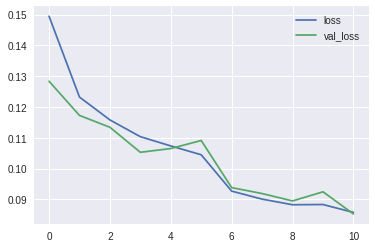

Epoch  11 9.996369e-06
Epoch 12/30
1448/3302 [============>.................] - ETA: 33:05 - loss: 0.0856 - acc: 0.9683 - f1_score_K: 0.2320

In [0]:
optimizer = Adam(0.00001, decay=0.00000001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', f1_score_K])


#model=load_model(filepath,custom_objects={'f1_score_K':f1_score_K})

model.fit_generator(generator=batch_generator_train(list(zip(train[0],train[1])), IMG_SIZE, BATCH),
                    steps_per_epoch=np.ceil(len(train[0])/BATCH),
                    epochs=30,
                    verbose=1,
                    validation_data=batch_generator_train(list(zip(val[0],val[1])), IMG_SIZE, 16),
                    validation_steps=np.ceil(len(val[0])/16),
                    callbacks=callbacks,
                    initial_epoch=0)
model.save(model_name)

In [0]:
os.listdir( '/content/gdrive/My Drive/atlas/models')

[]